<a href="https://colab.research.google.com/github/szendiagoston/TabNet/blob/main/TabNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch-tabnet
!pip install wget

from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.augmentations import ClassificationSMOTE
from pytorch_tabnet.pretraining import TabNetPretrainer

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)

import scipy

import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=55fa0b8446338ccc5a7a019522e9d1db01836f21e141d429a28ef03d70758556
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [10]:
torch.cuda.get_device_capability()

(7, 5)

In [79]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = f"1"

import torch
torch.__version__

'2.1.0+cu118'

In [9]:
from zipfile import ZipFile

from google.colab import files
upload = files.upload()

zip_file = ZipFile('archive.zip')
dfs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()
       if text_file.filename.endswith('.csv')}

KeyboardInterrupt: ignored

In [12]:
url = "https://github.com/szendiagoston/TabNet/raw/main/archive.zip"
import urllib.request as request
request.urlretrieve(url,'archive.zip')

zip_file = ZipFile('archive.zip')
dfs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()
       if text_file.filename.endswith('.csv')}

In [7]:
dfs['train.csv']

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,...,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58587,ID58588,0.355089,0.13,0.644231,C8,8794,2,A,M3,Petrol,...,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0
58588,ID58589,1.199642,0.02,0.519231,C14,7788,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
58589,ID58590,1.162273,0.05,0.451923,C5,34738,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
58590,ID58591,1.236307,0.14,0.557692,C8,8794,1,B2,M6,Petrol,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0


In [ ]:
[col for col in dfs['train.csv'].columns]

['policy_id',
 'policy_tenure',
 'age_of_car',
 'age_of_policyholder',
 'area_cluster',
 'population_density',
 'make',
 'segment',
 'model',
 'fuel_type',
 'max_torque',
 'max_power',
 'engine_type',
 'airbags',
 'is_esc',
 'is_adjustable_steering',
 'is_tpms',
 'is_parking_sensors',
 'is_parking_camera',
 'rear_brakes_type',
 'displacement',
 'cylinder',
 'transmission_type',
 'gear_box',
 'steering_type',
 'turning_radius',
 'length',
 'width',
 'height',
 'gross_weight',
 'is_front_fog_lights',
 'is_rear_window_wiper',
 'is_rear_window_washer',
 'is_rear_window_defogger',
 'is_brake_assist',
 'is_power_door_locks',
 'is_central_locking',
 'is_power_steering',
 'is_driver_seat_height_adjustable',
 'is_day_night_rear_view_mirror',
 'is_ecw',
 'is_speed_alert',
 'ncap_rating',
 'is_claim']

In [ ]:
[sum(dfs['train.csv'][col].isnull()) for col in dfs['train.csv'].columns] #nincs hiányzó adat

dfs['train.csv'].isna().any() #van-e hiányzó adat? -> nincs

policy_id                           False
policy_tenure                       False
age_of_car                          False
age_of_policyholder                 False
area_cluster                        False
population_density                  False
make                                False
segment                             False
model                               False
fuel_type                           False
max_torque                          False
max_power                           False
engine_type                         False
airbags                             False
is_esc                              False
is_adjustable_steering              False
is_tpms                             False
is_parking_sensors                  False
is_parking_camera                   False
rear_brakes_type                    False
displacement                        False
cylinder                            False
transmission_type                   False
gear_box                          

In [8]:
dfs['train.csv'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  object 
 1   policy_tenure                     58592 non-null  float64
 2   age_of_car                        58592 non-null  float64
 3   age_of_policyholder               58592 non-null  float64
 4   area_cluster                      58592 non-null  object 
 5   population_density                58592 non-null  int64  
 6   make                              58592 non-null  int64  
 7   segment                           58592 non-null  object 
 8   model                             58592 non-null  object 
 9   fuel_type                         58592 non-null  object 
 10  max_torque                        58592 non-null  object 
 11  max_power                         58592 non-null  object 
 12  engi

In [9]:
dfs['train.csv'].describe()

,policy_tenure,age_of_car,age_of_policyholder,population_density,make,airbags,displacement,cylinder,gear_box,turning_radius,length,width,height,gross_weight,ncap_rating,is_claim
count,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.00000,58592.000000,58592.000000,58592.000000
mean,0.611246,0.069424,0.469420,18826.858667,1.763722,3.137066,1162.355851,3.626963,5.245443,4.852893,3850.476891,1672.233667,1553.33537,1385.276813,1.759950,0.063968
std,0.414156,0.056721,0.122886,17660.174792,1.136988,1.832641,266.304786,0.483616,0.430353,0.228061,311.457119,112.089135,79.62227,212.423085,1.389576,0.244698
min,0.002735,0.000000,0.288462,290.000000,1.000000,1.000000,796.000000,3.000000,5.000000,4.500000,3445.000000,1475.000000,1475.00000,1051.000000,0.000000,0.000000
25%,0.210250,0.020000,0.365385,6112.000000,1.000000,2.000000,796.000000,3.000000,5.000000,4.600000,3445.000000,1515.000000,1475.00000,1185.000000,0.000000,0.000000
50%,0.573792,0.060000,0.451923,8794.000000,1.000000,2.000000,1197.000000,4.000000,5.000000,4.800000,3845.000000,1735.000000,1530.00000,1335.000000,2.000000,0.000000
75%,1.039104,0.110000,0.548077,27003.000000,3.000000,6.000000,1493.000000,4.000000,5.000000,5.000000,3995.000000,1755.000000,1635.00000,1510.000000,3.000000,0.000000
max,1.396641,1.000000,1.000000,73430.000000,5.000000,6.000000,1498.000000,4.000000,6.000000,5.200000,4300.000000,1811.000000,1825.00000,1720.000000,5.000000,1.000000


In [13]:
train = dfs['train.csv'].drop(columns = ['policy_id']) #id nem kell

nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 10: #Levettem 200-ról 10-re -> kicsit javított: best valid auc 0,66161
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        #train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    #else:
        #train.fillna(train.loc[train_indices, col].mean(), inplace=True)

area_cluster 22
make 5
segment 6
model 11
fuel_type 3
max_torque 9
max_power 9
engine_type 11
airbags 3
is_esc 2
is_adjustable_steering 2
is_tpms 2
is_parking_sensors 2
is_parking_camera 2
rear_brakes_type 2
displacement 9
cylinder 2
transmission_type 2
gear_box 2
steering_type 3
turning_radius 9
length 9
is_front_fog_lights 2
is_rear_window_wiper 2
is_rear_window_washer 2
is_rear_window_defogger 2
is_brake_assist 2
is_power_door_locks 2
is_central_locking 2
is_power_steering 2
is_driver_seat_height_adjustable 2
is_day_night_rear_view_mirror 2
is_ecw 2
is_speed_alert 2
ncap_rating 5
is_claim 2


In [14]:
import sklearn.model_selection as ms

In [ ]:
ms.train_test_split? #HF

SyntaxError: ignored

In [15]:
target = 'is_claim'

if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid"], p =[.9, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
#test_indices = train[train.Set=="test"].index

In [16]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]]

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [ ]:
cat_idxs #plicy_tenure kivételével mind az...

[3,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41]

grouped_features???

In [76]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

#X_test = train[features].values[test_indices]
#y_test = train[target].values[test_indices]

In [77]:
# TabNetPretrainer
EMB_DIM = 32
unsupervised_model = TabNetPretrainer(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=EMB_DIM,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax', # "sparsemax",
    n_shared_decoder=1, # nb shared glu for decoding
    n_indep_decoder=1, # nb independent glu for decoding
#     grouped_features=[[0, 1]], # you can group features together here
    verbose=5,
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [80]:
max_epochs = 50 if not os.getenv("CI", False) else 2

In [87]:
unsupervised_model.fit(
    X_train=smote_X,
    eval_set=[X_valid],
    max_epochs=max_epochs , patience=5,
    batch_size=2048, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.5,
)

epoch 0  | loss: 243.41975| val_0_unsup_loss_numpy: 2.074810028076172|  0:00:05s
epoch 5  | loss: 0.76014 | val_0_unsup_loss_numpy: 0.7010700106620789|  0:00:28s
epoch 10 | loss: 0.59878 | val_0_unsup_loss_numpy: 0.5291500091552734|  0:00:51s
epoch 15 | loss: 0.22541 | val_0_unsup_loss_numpy: 0.14565999805927277|  0:01:14s
epoch 20 | loss: 0.09059 | val_0_unsup_loss_numpy: 0.07524000108242035|  0:01:37s
epoch 25 | loss: 0.14861 | val_0_unsup_loss_numpy: 0.08764000236988068|  0:01:59s
epoch 30 | loss: 0.06629 | val_0_unsup_loss_numpy: 0.05646999925374985|  0:02:21s
epoch 35 | loss: 0.05975 | val_0_unsup_loss_numpy: 0.051920000463724136|  0:02:46s
epoch 40 | loss: 0.05936 | val_0_unsup_loss_numpy: 0.05772000178694725|  0:03:10s

Early stopping occurred at epoch 40 with best_epoch = 35 and best_val_0_unsup_loss_numpy = 0.051920000463724136


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
y_train.mean() #smote kell -> kell, mert csak 6% a kárigények aránya.

0.06446785132421476

In [75]:
aug = ClassificationSMOTE(p=0.2)
y_train.mean() #nem  változik, mert this will average a percentage p of the elements in the batch with other elements. The target will stay unchanged and keep the value of the most important row in the mix.
#Ez alapján nem értem, milyen p kéne...
#Ettől nem igazán javult: best valid auc 0,6251 lett...

0.06372056901483152

In [88]:
tabnet_params = {"cat_idxs":cat_idxs,
                 "cat_dims":cat_dims,
                 "cat_emb_dim":EMB_DIM,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2), #Ha 0.2-re veszem, akkor romlik kicsit: best valid auc 0,60606
                 "scheduler_params":{"step_size":50, #elég 10? # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax', # "sparsemax"
                 #"grouped_features" : grouped_features
                 "seed":2023
                }

clf = TabNetClassifier(**tabnet_params
                      )

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [89]:
unsupervised_model.device

device(type='cuda')

In [102]:
os = SMOTE(random_state = 0)
smote_X, smote_y = os.fit_resample(X_train, y_train)
smote_y.mean() #fele-fele arány lett

0.5

In [107]:
# This illustrates the behaviour of the model's fit method using Compressed Sparse Row matrices
sparse_X_train = scipy.sparse.csr_matrix(smote_X)  # Create a CSR matrix from X_train
sparse_X_valid = scipy.sparse.csr_matrix(X_valid)  # Create a CSR matrix from X_valid

# Fitting the model
clf.fit(
    X_train=sparse_X_train, y_train=smote_y,
    eval_set=[(sparse_X_train, smote_y), (sparse_X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['auc', 'accuracy'],
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128, #túl magas? -> nem
    num_workers=0,
    weights=1,
    drop_last=False,
    #augmentations=aug, #aug, None
    from_unsupervised=unsupervised_model
)

#nagyobb patience vagy tanulási ráta segíthet -> Nem igazán, fentebb írom learning rate-nél.

#előtanítás segíthet -> nem, best valid auc 0,66416, de valószínűleg tovább kéne csinálni a pretraininget és/vagy a patience-t, mert ott max epochnál állt meg, itt meg max patience-nél.

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.72792 | train_auc: 0.51717 | train_accuracy: 0.51203 | valid_auc: 0.53216 | valid_accuracy: 0.64235 |  0:00:27s
epoch 1  | loss: 0.6827  | train_auc: 0.544   | train_accuracy: 0.53012 | valid_auc: 0.54318 | valid_accuracy: 0.55423 |  0:00:55s
epoch 2  | loss: 0.66945 | train_auc: 0.56884 | train_accuracy: 0.53697 | valid_auc: 0.55597 | valid_accuracy: 0.55906 |  0:01:22s
epoch 3  | loss: 0.66394 | train_auc: 0.59818 | train_accuracy: 0.55704 | valid_auc: 0.57053 | valid_accuracy: 0.57976 |  0:01:50s
epoch 4  | loss: 0.65644 | train_auc: 0.641   | train_accuracy: 0.59976 | valid_auc: 0.5892  | valid_accuracy: 0.45163 |  0:02:16s
epoch 5  | loss: 0.64837 | train_auc: 0.64664 | train_accuracy: 0.6127  | valid_auc: 0.60941 | valid_accuracy: 0.55096 |  0:02:43s
epoch 6  | loss: 0.64297 | train_auc: 0.66219 | train_accuracy: 0.61319 | valid_auc: 0.6029  | valid_accuracy: 0.60873 |  0:03:10s
epoch 7  | loss: 0.63849 | train_auc: 0.66143 | train_accuracy: 0.60596 | valid_auc

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


## Comparing to logit model
Használt oldalak:

*   https://learn.theprogrammingfoundation.org/getting_started/intro_data_science/module4/?gclid=CjwKCAiAxreqBhAxEiwAfGfndJ7ktwBSs5bRoYVpD5I0F4FLMqFK-xSyzT5eA7abKVk3KR7GTfnBHBoC5wEQAvD_BwE
*   https://www.datacamp.com/tutorial/understanding-logistic-regression-python?utm_source=google&utm_medium=paid_search&utm_campaignid=19589720824&utm_adgroupid=157156376311&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=679431869741&utm_targetid=dsa-2218886984100&utm_loc_interest_ms=&utm_loc_physical_ms=9063089&utm_content=&utm_campaign=230119_1-sea~dsa~tofu_2-b2c_3-row-p2_4-prc_5-na_6-na_7-le_8-pdsh-go_9-na_10-na_11-na-fawnov23&gad_source=1&gclid=CjwKCAiAxreqBhAxEiwAfGfndHQWaA8-5hNGA_EHbWsssS46TH0d2DkTjISQPbY951OHwzIxGxm1cxoC0HcQAvD_BwE
*   https://medium.com/@rithpansanga/logistic-regression-for-feature-selection-selecting-the-right-features-for-your-model-410ca093c5e0



In [40]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
import math
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE

In [96]:
os = SMOTE(random_state = 0)
smote_X, smote_y = os.fit_resample(X_train, y_train)
smote_y.mean() #fele-fele arány lett

0.5

In [84]:
logreg = LogisticRegression(random_state = 0)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_valid)
cnf_matrix = metrics.confusion_matrix(y_valid, y_pred)
cnf_matrix

array([[5415,    0],
       [ 384,    0]])

Text(0.5, 427.9555555555555, 'Predicted label')

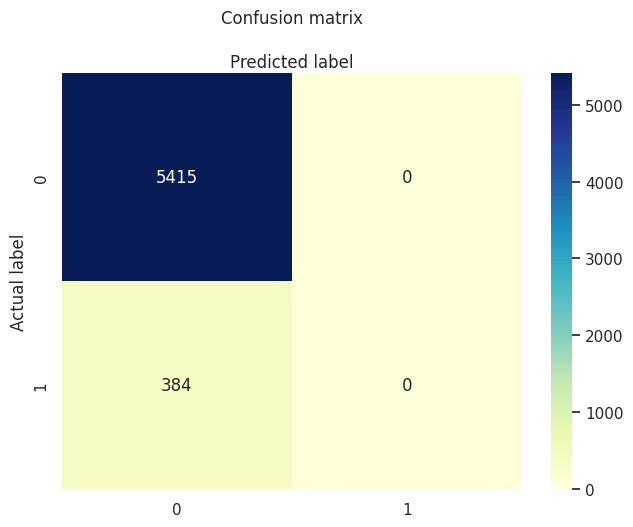

In [85]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [61]:
# Use RFE to select the top 10 features
rfe = RFE(logreg, n_features_to_select=10)
rfe.fit(smote_X, smote_y)

# Print the selected features
print(rfe.support_)

[ True False False  True  True  True False False False  True  True False
 False False False False False False False False False False False False
  True False  True  True  True False False False False False False False
 False False False False False False]


In [49]:
X_train[:,1]

array([0.05, 0.02, 0.02, ..., 0.05, 0.14, 0.02])

In [47]:
smote_X[:, rfe.support_]

array([[5.15873590e-01, 0.00000000e+00, 4.99000000e+03, ...,
        1.51500000e+03, 1.47500000e+03, 1.18500000e+03],
       [6.72618514e-01, 1.10000000e+01, 2.70030000e+04, ...,
        1.51500000e+03, 1.47500000e+03, 1.18500000e+03],
       [8.41110256e-01, 1.50000000e+01, 4.07600000e+03, ...,
        1.51500000e+03, 1.47500000e+03, 1.18500000e+03],
       ...,
       [7.44380507e-02, 3.00000000e+00, 3.47910000e+04, ...,
        1.79000000e+03, 1.63500000e+03, 1.72000000e+03],
       [4.94906864e-01, 4.00000000e+00, 5.41000000e+03, ...,
        1.47500000e+03, 1.82500000e+03, 1.51000000e+03],
       [2.75978945e-01, 2.00000000e+00, 6.10800000e+03, ...,
        1.74500000e+03, 1.50000000e+03, 1.41000000e+03]])

In [68]:
logreg = LogisticRegression(random_state = 0)
logreg.fit(smote_X[:, rfe.support_], smote_y)
y_pred_rfe = logreg.predict(X_valid[:, rfe.support_])
cnf_matrix = metrics.confusion_matrix(y_valid, y_pred)
cnf_matrix

array([[2365, 3050],
       [ 172,  212]])

In [74]:
smote_X == smote_X[:, rfe.support_]

<ipython-input-74-5520262a1333>:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  smote_X == smote_X[:, rfe.support_]


False

In [70]:
all(y_pred_rfe == y_pred) #Nem használt semmit a változószelekció... TabNet jobb, de logit még rosszabb, mint a véletlen, úgyhogy nem csoda...

True

In [35]:
auc = metrics.roc_auc_score(y_valid, y_pred)
auc

0.4944165512465375

In [37]:
acc = logreg.score(X_valid, y_valid)
acc

0.44438696326952926